
# **Feather Pal**

## **Project Overview**

This project focuses on building a robust deep learning model for bird species
classification using TensorFlow and the EfficientNetB0 architecture. The dataset consists of a diverse collection of bird images, and the goal is to train a model that accurately identifies and classifies different bird species.

## **Dataset**

The dataset is loaded from a CSV file named 'birds.csv', encompassing essential details such as class ID, file paths, labels, data sets, and scientific names. The dataset, comprising 89,885 entries and 5 columns, is meticulously divided into training (84,635 entries), validation (2,625 entries), and testing (2,625 entries) sets.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/FeatherPal/kaggle.json .

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'

!kaggle datasets download -d gpiosenka/100-bird-species

!unzip -q -o /content/100-bird-species.zip
!rm /content/100-bird-species.zip

100% 1.95G/1.96G [00:21<00:00, 93.5MB/s]
100% 1.96G/1.96G [00:21<00:00, 99.3MB/s]


## **Import Libraries**

This section initializes crucial data science libraries and frameworks for proceeding with the project. The libraries fall into the following categories:

- Data Science Libraries
- Tensorflow Libraries
- System libraries
- Visualization Libraries
- Metrics

In [ ]:
# Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.optimizers import Adam
from keras.applications import MobileNetV2
from keras import Model
from keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
import random
import warnings

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import cv2

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [ ]:
data = pd.read_csv('/content/birds.csv')
data.head(5)

class id                      filepaths           labels data set  \
0       0.0  train/ABBOTTS BABBLER/001.jpg  ABBOTTS BABBLER    train   
1       0.0  train/ABBOTTS BABBLER/007.jpg  ABBOTTS BABBLER    train   
2       0.0  train/ABBOTTS BABBLER/008.jpg  ABBOTTS BABBLER    train   
3       0.0  train/ABBOTTS BABBLER/009.jpg  ABBOTTS BABBLER    train   
4       0.0  train/ABBOTTS BABBLER/002.jpg  ABBOTTS BABBLER    train   

        scientific name  
0  MALACOCINCLA ABBOTTI  
1  MALACOCINCLA ABBOTTI  
2  MALACOCINCLA ABBOTTI  
3  MALACOCINCLA ABBOTTI  
4  MALACOCINCLA ABBOTTI

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89885 entries, 0 to 89884
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   class id         89885 non-null  float64
 1   filepaths        89885 non-null  object 
 2   labels           89885 non-null  object 
 3   data set         89885 non-null  object 
 4   scientific name  89885 non-null  object 
dtypes: float64(1), object(4)
memory usage: 3.4+ MB


## **Data Analysis**

This section begins with a glance at the distribution of bird species and the dataset split into training, validation, and testing sets. The counts of unique bird species and the distribution across different datasets are displayed.

Next, separate data frames are created for each category (training, validation, and testing). A bar chart visualizes the top 20 bird species labels, providing insights into the dataset's composition.

Finally, a selection of 16 images from the dataset is displayed along with their corresponding labels, offering a visual representation of the bird species in the dataset. This exploratory data analysis serves as an initial exploration before diving into model development and training.

In [ ]:
species_count = data['labels'].value_counts()
split_count = data['data set'].value_counts()

print(f'Number of unique Bird Species: \n\n{data["labels"].nunique()}\n')
print(f'Species and their Count:\n\n{species_count}')
print(f'\nTraining, Validation and Testing Split:\n\n{split_count}')

Number of unique Bird Species: 

525

Species and their Count:

RUFOUS TREPE               273
HOUSE FINCH                258
D-ARNAUDS BARBET           243
OVENBIRD                   243
ASIAN GREEN BEE EATER      230
                          ... 
NORTHERN RED BISHOP        140
SNOWY PLOVER               140
PATAGONIAN SIERRA FINCH    140
EURASIAN GOLDEN ORIOLE     140
RED TAILED THRUSH          140
Name: labels, Length: 525, dtype: int64

Training, Validation and Testing Split:

train    84635
test      2625
valid     2625
Name: data set, dtype: int64


In [ ]:
# Create separate data frames for each category
train_ds = data[data['data set'] == 'train']
val_ds = data[data['data set'] == 'valid']
test_ds = data[data['data set'] == 'test']

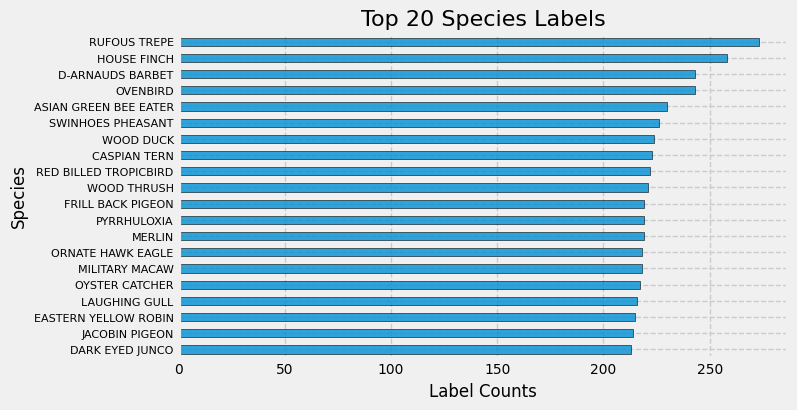

In [ ]:
plt.figure(figsize=(7, 4))
plt.style.use('fivethirtyeight')

species_count[:20].sort_values(ascending=True).plot(kind='barh', alpha=0.8, edgecolor='k')

plt.title('Top 20 Species Labels', fontsize=16)
plt.xlabel('Label Counts', fontsize=12)
plt.ylabel('Species', fontsize=12)
plt.grid(True, linestyle='--')
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=8)

plt.show()

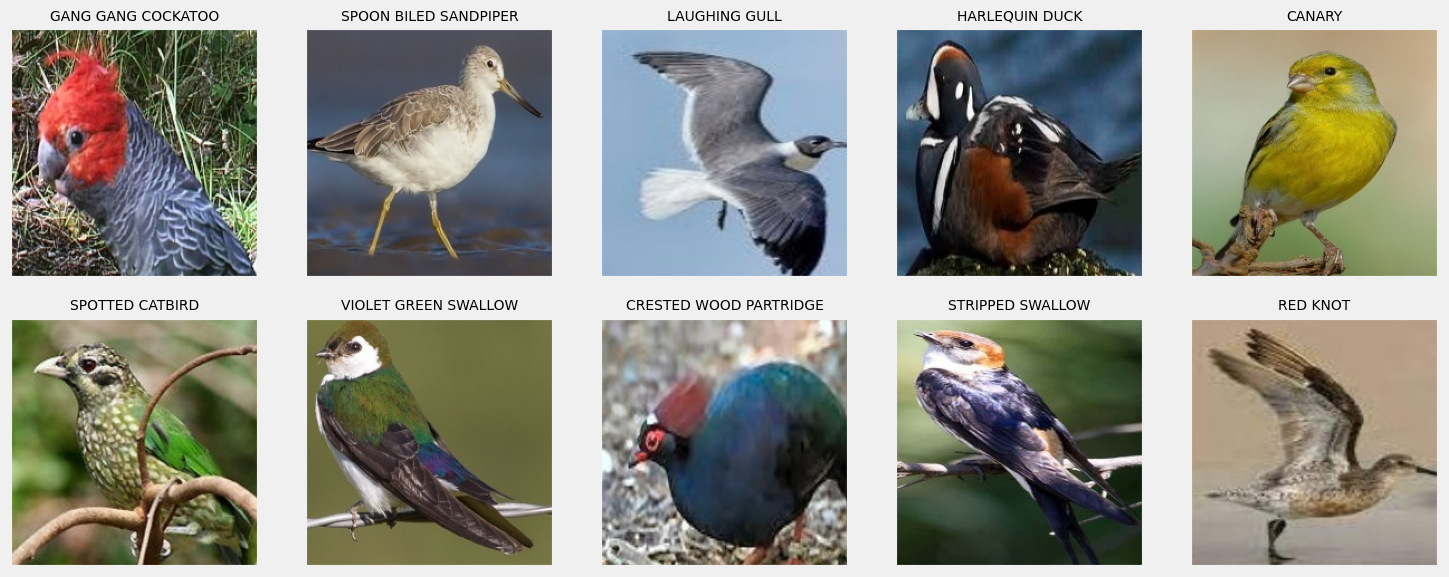

In [ ]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(data), 16)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data['filepaths'][random_index[i]]))
    ax.set_title(data.labels[random_index[i]], fontsize=10)
plt.tight_layout()
plt.show()

## **Data Loading and Augmentation**

This section focuses on preparing the dataset for training by splitting it into training and testing sets. Using the `train_test_split` function, 20% of the data is allocated for testing, ensuring a random and representative split.

Subsequently, ImageDataGenerators are employed for both training and testing, incorporating preprocessing functions from the EfficientNet model. These generators facilitate real-time data augmentation, resizing images to the target size of (224, 224), and normalizing pixel values.

The dataset is further categorized into training, validation, and testing subsets using the `flow_from_dataframe` method. These subsets are crucial for training and evaluating the model's performance. The specified data augmentation steps include resizing, rescaling, random horizontal flipping, rotation, zooming, and contrast adjustments.

This preprocessing and augmentation step ensures that the model is exposed to diverse variations of the input data during training, enhancing its ability to generalize well to unseen examples.

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [ ]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [ ]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

## **Modelling - EfficientNetB0**

In this section, a pretrained EfficientNetB0 model is employed for bird species classification. The model is loaded with weights pre-trained on ImageNet and the top classification layer removed, preparing it for transfer learning.

The model's layers are frozen (pretrained_model.trainable = False), ensuring that the previously learned features are not modified during the initial training phase.

To prevent overfitting and optimize training, several callbacks are incorporated:

    EarlyStopping: Monitors the validation loss and halts training if it doesn't improve for 5 consecutive epochs, restoring the best weights.
    ReduceLROnPlateau: Adjusts the learning rate if the validation loss plateaus, potentially aiding convergence.

TensorBoard logging is set up to visualize training and validation metrics during training.A custom augmentation pipeline is applied to the model inputs, enhancing its exposure to diverse variations of the input data during training.

The modified architecture includes additional dense layers and dropout for regularization, concluding with a softmax activation layer for multi-class classification.

Training unfolds over 150 epochs, with the specified callbacks monitoring and controlling the training process.

Visualizations of training and validation loss, as well as accuracy curves, are displayed to assess the model's performance over the epochs.

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 5 epochs in a row, stop training

# Setup decaying Learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Log data for TensorBoard
log_dir = "logs"  # Specify your log directory
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Setup TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)


outputs = Dense(524, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=150,
    callbacks=[
        early_stopping,
        tensorboard_callback,
        reduce_lr
    ]
)

Epoch 1/150
1795/1795 [==============================] - 166s 89ms/step - loss: 5.3740 - accuracy: 0.0630 - val_loss: 2.8482 - val_accuracy: 0.4354 - lr: 1.0000e-04
Epoch 2/150
1795/1795 [==============================] - 168s 93ms/step - loss: 3.0126 - accuracy: 0.3126 - val_loss: 1.4499 - val_accuracy: 0.6933 - lr: 1.0000e-04
Epoch 3/150
1795/1795 [==============================] - 168s 94ms/step - loss: 2.2005 - accuracy: 0.4563 - val_loss: 1.0458 - val_accuracy: 0.7680 - lr: 1.0000e-04
Epoch 4/150
1795/1795 [==============================] - 153s 85ms/step - loss: 1.7857 - accuracy: 0.5458 - val_loss: 0.8428 - val_accuracy: 0.8060 - lr: 1.0000e-04
Epoch 5/150
1795/1795 [==============================] - 169s 94ms/step - loss: 1.5376 - accuracy: 0.6020 - val_loss: 0.7247 - val_accuracy: 0.8236 - lr: 1.0000e-04
Epoch 6/150
1795/1795 [==============================] - 153s 85ms/step - loss: 1.3586 - accuracy: 0.6441 - val_loss: 0.6416 - val_accuracy: 0.8449 - lr: 1.0000e-04
Epoch 7/15

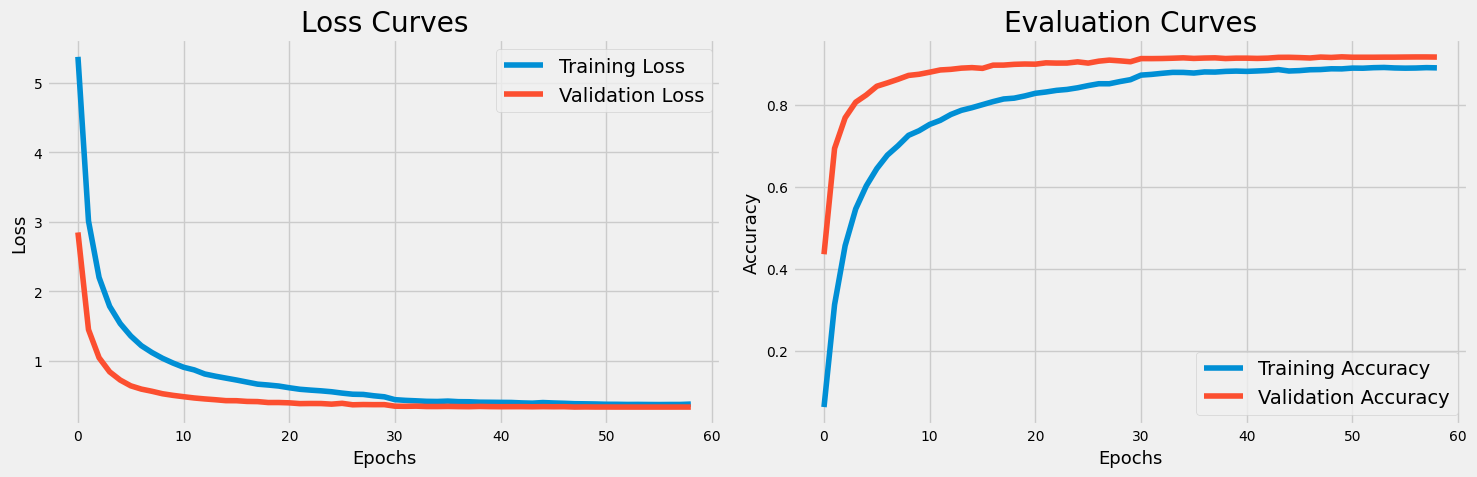

In [ ]:
# Visualise loss and evaluation curves
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

num_epochs = range(len(accuracy))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(num_epochs, loss, label='Training Loss')
ax[0].plot(num_epochs, val_loss, label='Validation Loss')
ax[0].set_title('Loss Curves')
ax[0].set_xlabel('Epochs', fontsize=13)
ax[0].set_ylabel('Loss', fontsize=13)
ax[0].tick_params(axis='x', labelsize=10)
ax[0].tick_params(axis='y', labelsize=10)
ax[0].legend()

ax[1].plot(num_epochs, accuracy, label='Training Accuracy')
ax[1].plot(num_epochs, val_accuracy, label='Validation Accuracy')
ax[1].set_title('Evaluation Curves')
ax[1].set_xlabel('Epochs', fontsize=13)
ax[1].set_ylabel('Accuracy', fontsize=13)
ax[1].tick_params(axis='x', labelsize=10)
ax[1].tick_params(axis='y', labelsize=10)
ax[1].legend()

plt.tight_layout()

plt.show()

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

# Assuming 'model' is your trained model
# model.save('./FeatherPal.h5')

Test Loss: 0.33336
Test Accuracy: 91.61%


## **Model Evaluation**

This section assesses the model's performance by predicting bird species labels on the testing set and comparing them with the true labels.

To provide a visual representation of the model's predictions, 10 random indices from the test set are selected. The title color is specified as green for correct predictions and red for incorrect ones.

This section also includes the following sub-sections:
- Classification Report
- GradCAM Visualisation

This section encapsulates the final step of model evaluation, offering insights into its ability to correctly classify bird species based on the testing set.

In [ ]:
# Get the mapping between class indices and class names
class_indices_mapping = test_images.class_indices

# Reverse the mapping to get a dictionary of class names to indices
class_names_mapping = {v: k for k, v in class_indices_mapping.items()}

# Access the label names for all observations in test_images
test_labels = [class_names_mapping[idx] for idx in test_images.classes]

# Display the label names for the first few observations
print("\nTrue Labels of the first 10 observations: ", test_labels[:10])
print()

# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_labels = [labels[k] for k in pred]

# Display the result
print(f'\nPredicted Labels of the first 10 observations: {pred_labels[:10]}')


True Labels of the first 10 observations:  ['DEMOISELLE CRANE', 'CANVASBACK', 'CHIPPING SPARROW', 'AMERICAN ROBIN', 'EASTERN BLUEBIRD', 'HAWFINCH', 'INDIAN ROLLER', 'ECUADORIAN HILLSTAR', 'NORTHERN JACANA', 'LITTLE AUK']

561/561 [==============================] - 39s 69ms/step

Predicted Labels of the first 10 observations: ['DEMOISELLE CRANE', 'CANVASBACK', 'CHIPPING SPARROW', 'AMERICAN ROBIN', 'EASTERN BLUEBIRD', 'HAWFINCH', 'INDIAN ROLLER', 'ECUADORIAN HILLSTAR', 'NORTHERN JACANA', 'LITTLE AUK']


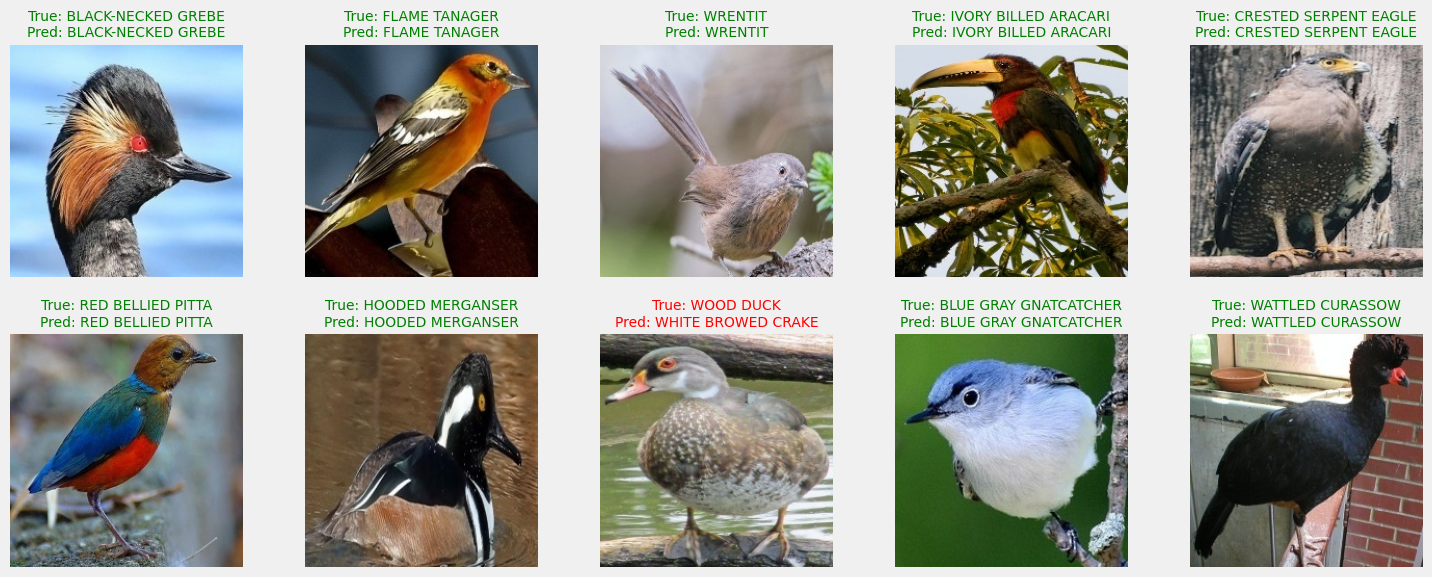

In [ ]:
# Select 10 random indices from the test set
random_indices = random.sample(range(len(test_images.filepaths)), 10)

# Create a subplot with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, idx in enumerate(random_indices):
    # Load the image using matplotlib
    img_path = test_images.filepaths[idx]
    img = mpimg.imread(img_path)

    # Display the image
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis('off')

    # Get true and predicted labels
    true_label = test_labels[idx]
    pred_label = pred_labels[idx]

    # Determine the title color
    title_color = 'green' if true_label == pred_label else 'red'

    # Display true and predicted labels as title with specified color
    title = f'True: {true_label}\nPred: {pred_label}'
    axes[i // 5, i % 5].set_title(title, fontsize=10, color=title_color)

plt.tight_layout()
plt.show()


### **Classification Report**

In this section, the model's performance is comprehensively evaluated using a classification report. The classification_report function from scikit-learn is employed to generate key classification metrics, including precision, recall, F1-score, and support for each class.

The results are stored in a DataFrame (report_df) for easy interpretation and further analysis. This DataFrame presents a detailed overview of the model's performance across different bird species.

Uncommenting the provided code would allow saving the classification report to a CSV file named classification_report.csv for future reference or sharing.

In [ ]:
report = classification_report(test_labels, pred_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print('Classification Report: \n')
print(report_df)

# Uncomment to save the report
# report_df.to_csv('classification_report.csv', index=True)

Classification Report: 

                            precision    recall  f1-score       support
ABBOTTS BABBLER              0.821429  0.851852  0.836364     27.000000
ABBOTTS BOOBY                0.742857  0.787879  0.764706     33.000000
ABYSSINIAN GROUND HORNBILL   0.956522  0.897959  0.926316     49.000000
AFRICAN CROWNED CRANE        1.000000  1.000000  1.000000     27.000000
AFRICAN EMERALD CUCKOO       0.933333  0.875000  0.903226     32.000000
...                               ...       ...       ...           ...
YELLOW HEADED BLACKBIRD      0.967742  0.769231  0.857143     39.000000
ZEBRA DOVE                   1.000000  0.972973  0.986301     37.000000
accuracy                     0.916137  0.916137  0.916137      0.916137
macro avg                    0.916989  0.915192  0.914316  17946.000000
weighted avg                 0.918672  0.916137  0.915711  17946.000000

[527 rows x 4 columns]


### **GradCAM Visulaisation**

This section employs Grad-CAM (Gradient-weighted Class Activation Mapping) to visualize the regions of an image that are crucial for the model's classification decision.

Two functions, make_gradcam_heatmap and save_and_display_gradcam, are defined to generate and display Grad-CAM heatmaps. The first function computes the heatmap, highlighting regions relevant to the model's decision, while the second function overlays this heatmap onto the original image for visualization.

The code snippet then demonstrates the application of Grad-CAM on a subset of test images. For each selected image, the Grad-CAM heatmap is generated and superimposed onto the original image. These visualizations showcase the areas of focus for the model when making predictions.

This section serves as a powerful interpretability tool, providing insights into the model's decision-making process and highlighting the regions of input images contributing to its classifications.

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

<ipython-input-150-252b7d25d358>:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


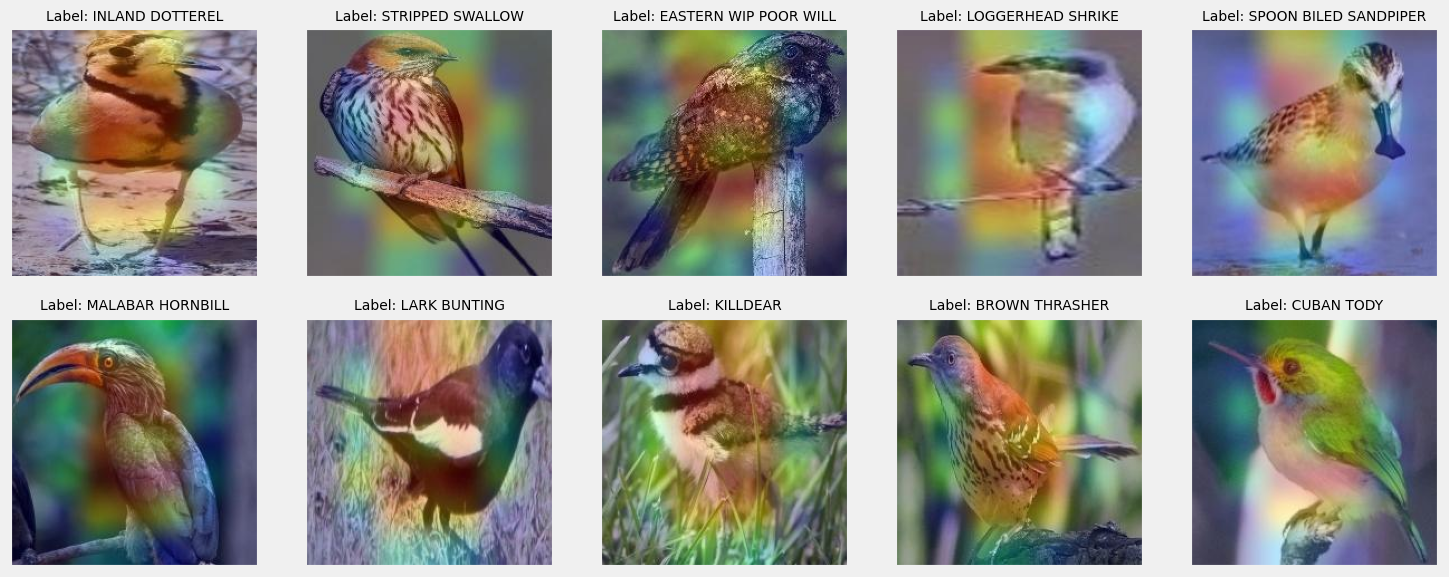

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df['filepaths'].iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"Label: {test_df['labels'].iloc[random_index[i]]}", fontsize=10)
plt.tight_layout()
plt.show()

# **Conclusion**

The completion of this project marks a significant achievement in the realm of image classification using deep learning techniques. The goal was to develop an efficient model capable of accurately categorizing diverse images into a wide range of classes. The use case here involved classifying images into 524 different categories, showcasing the model's ability to handle a large and varied dataset.

## **Model Architecture and Training**

The project utilized the EfficientNetB0 architecture as the backbone of the classification model, leveraging pre-trained weights on the ImageNet dataset. This not only expedited the training process but also allowed the model to capture intricate features in the images. The model was fine-tuned with additional layers to adapt to the specific classification task.

Training involved a carefully designed pipeline, including data augmentation to enhance the model's robustness. The training history indicates a remarkable evolution of the model's performance over the epochs. Starting with an initial loss of 5.3740 and accuracy of 6.3%, the model steadily improved, reaching a training accuracy of 88.96% and validation accuracy of 91.59%. The validation loss consistently decreased, demonstrating the model's ability to generalize well to previously unseen data.

## **Performance Evaluation**

To assess the model's performance, it was evaluated on a separate test dataset. The classification report provided detailed metrics, including precision, recall, and F1-score for each class. The overall accuracy on the test set further affirmed the model's competence in making accurate predictions.

## **Interpretability with Grad-CAM**

Beyond performance metrics, the project incorporated Grad-CAM visualizations to interpret and understand the model's decision-making process. These visualizations provided insights into the regions of input images that significantly influenced the model's predictions. Such interpretability tools are crucial for building trust in the model's decisions and identifying potential areas for improvement.

## **Future Directions**

While the current model demonstrates strong performance, there are avenues for further exploration. Fine-tuning hyperparameters, experimenting with different architectures, and increasing the diversity of the dataset could enhance the model's capabilities. Additionally, deploying the model in real-world scenarios and monitoring its performance over time would be crucial.

In conclusion, this project successfully navigated the complexities of image classification, showcasing the potential of deep learning in handling large and diverse datasets. The model's achievements in accuracy and interpretability lay the foundation for future advancements in similar tasks and underscore the potential of deep learning in image-based applications.